# Compiling Circuits for EeroQ via Qiskit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/eeroq/eeroq_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/eeroq/eeroq_qss.ipynb)

## Import Requirements

This tutorial will showcase how to compile a circuit for EeroQ hardware using the ```qiskit-superstaq``` client. 

In [1]:
# Required imports
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_superstaq as qss

# Optional imports
import numpy as np
import os  # Used if setting a token as an environment variable

%load_ext autoreload
%autoreload 2

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API))

In [2]:
service = qss.superstaq_provider.SuperstaqProvider()

## EeroQ Gates

One of the native gates that EeroQ devices operate is the Dipole-Dipole (DD) gate, which couples two electrons. This gate can be applied to electrons within a qubit to perform rotation gates, or across qubits to perform entangling gates. The DD gate is available as a custom gate in qiskit-superstaq.

In [3]:
dd_gate = qss.DDGate(1)
dd_gate

qss.DDGate(1)

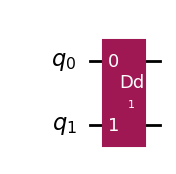

In [4]:
qc = qiskit.QuantumCircuit(2)
qc.append(dd_gate, [0, 1])
qc.draw("mpl")

Below is the EeroQ protocol for a CZ Gate.

![title](images/DD_gate.png)

We can compile to the EeroQ Wonderlake device by instantiating an EeroQ backend. We can then call the `backend.compile` method.

In [5]:
def count_gates(qc: qiskit.QuantumCircuit):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count


def remove_idle_wires(qc: qiskit.QuantumCircuit):
    qc_out = qc.copy()
    gate_count = count_gates(qc_out)
    for qubit, count in gate_count.items():
        if count == 0:
            qc_out.qubits.remove(qubit)
    return qc_out

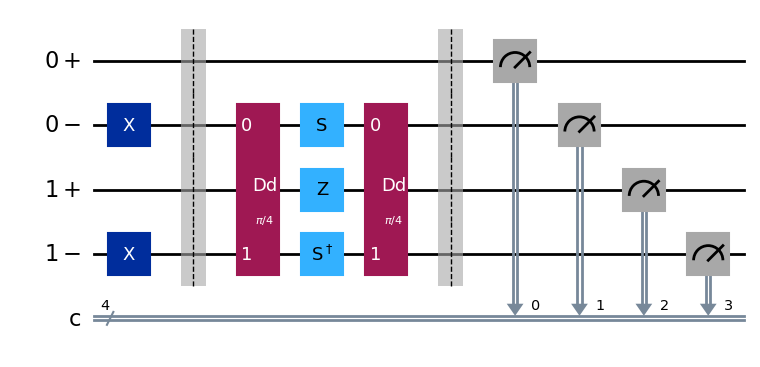

In [6]:
qc = qiskit.QuantumCircuit(2)
qc.cz(0, 1)
qc.measure_all()
backend = service.get_backend("eeroq_wonderlake_qpu")
compiled_circuit = backend.compile(qc).circuit
remove_idle_wires(compiled_circuit).draw("mpl")

As we can see, the initial circuit and compiled circuit have equivalent unitaries, despite the difference in circuit width. We can also simulate this circuit using the `backend.run` method. As expected, all measurements are in the 00 state.

In [7]:
job = backend.run(qc, shots=10, method="dry-run")

In [8]:
print(job.result().get_counts())

{'00': 10}


## Circuit Compilation

We can repeat the above experiment with larger circuits to see how they compile.

In [9]:
from qiskit.circuit.random import random_circuit

qc = random_circuit(2, 3, measure=False)
qc.draw()

┌───┐   ┌─────┐        ┌───┐     
q_0: ┤ H ├───┤ Sdg ├────────┤ Y ├─────
     └─┬─┘┌──┴─────┴───┐┌───┴───┴────┐
q_1: ──■──┤ P(0.39452) ├┤ Rx(2.2911) ├
          └────────────┘└────────────┘

In [10]:
backend = service.get_backend("eeroq_wonderlake_qpu")

In [11]:
cc = backend.compile(qc).circuit

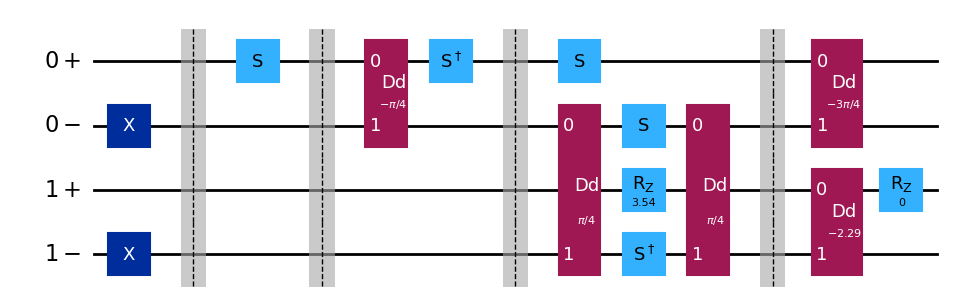

In [12]:
remove_idle_wires(cc).draw("mpl")

## Circuit Simulation

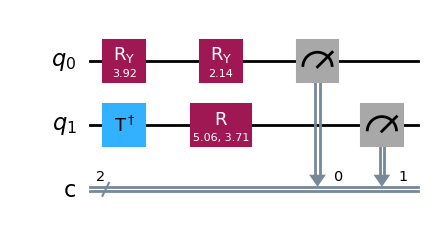

In [13]:
from qiskit.circuit.random import random_circuit

qc = random_circuit(2, 3, measure=True)
qc.draw("mpl")

We can perform noisy simulation by setting the "method='noise-sim'" and specifying an error rate.

In [14]:
job = backend.run(qc, shots=100, method="noise-sim", error_rate=0.01)

In [15]:
print(job.result().get_counts())

{'00': 63, '10': 34, '01': 1, '02': 1, '20': 1}


A measurement value of 2 refers to an out-of-codespace error.